In [33]:
from os import chdir
chdir("../general")
from models import *
from util import *
from observation import *
chdir("../case-studies")

from fenics import *
from mshr import *

import numpy as np
from numpy import random
from numpy import linalg as linalg
from scipy import sparse
from scipy.sparse import linalg as splinalg

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib

from decimal import Decimal
from sksparse import cholmod

In [2]:
def pprint(num):
	print('%.2E' % Decimal(num))

In [3]:
random.seed(3122344)

In [4]:
# Create mesh and define function space
xL = 0
xR = 30
expand = 0
xL -= expand
xR += expand
num_pt = 750
mesh = IntervalMesh(num_pt,xL,xR)
V = FunctionSpace(mesh, 'P', 1)
fem = V.element()

In [5]:
# Define our source problem parameters
alpha = 2			  # twice the number of recursive applications
d = 1				  # dimension of the space
nu = alpha-d/2		  # matern nu parameter
rho = 2  			  # range
kappa = np.sqrt(8*nu)/rho   # matern kappa parameter
sigma2 = 10            # variance of the source

In [6]:
# Define our mechanics problem parameters
diff = 0.75
diffusion = Constant(diff)
dec = 0.2
decay = Constant(dec)
advection = Expression("0.5 + 0.1*cos(6.283*(x[0]-10)/10) + 0.075*cos(9.425*(x[0]-10)/10) + 0.075*cos(15.708*(x[0]-10)/10)",degree=2,domain=mesh)
def adv(x):
	return 0.5 + 0.1*np.cos(6.283*x/10) + 0.075*cos(9.425*x/10) + 0.075*cos(15.708*x/10)
adv0 = str(adv(xL))
adv1 = str(adv(xR))
strL = "(" + str(xL) + ")"
strR = "(" + str(xR) + ")"
termL = "(" + strR + "-x[0])/(" + strR + "-" + strL + ")"
termR = "(x[0] - " + strL +")/(" + strR + "-" + strL + ")"
print("-" + adv0 + "*" + termL + " + " + adv1 + "*" + termR)
adv_BC = Expression("-" + adv0 + "*" + termL + " + " + adv1 + "*" + termR,degree=1,domain=mesh)


-0.7499999999999999*((30)-x[0])/((30)-(0)) + 0.45000000164216086*(x[0] - (0))/((30)-(0))


In [7]:
# Define the source matrix
Q_source = make_matern(alpha,kappa,d,V,sigma2,threshold=1e-10)
Q_factors = make_matern_factors(alpha,kappa,d,V,sigma2)

In [8]:
# Define the source function and FEM representation of it
farm = Expression("x[0] <= 10 ? 1 : 0",degree=1)
industrial = Expression("x[0] <= 20 & x[0] > 10 ? 1 : 0",degree=1)
residential = Expression("x[0] > 20 ? 1 : 0",degree=1)

In [9]:
farm_f = Function(V)
farm_f.interpolate(farm)

ind_f = Function(V)
ind_f.interpolate(industrial)

res_f = Function(V)
res_f.interpolate(residential)

farm_vec = func_to_vec(farm_f)
ind_vec = func_to_vec(ind_f)
res_vec = func_to_vec(res_f)

In [10]:
mu_beta = 20
sigma_beta = 5
X = np.array([farm_vec,ind_vec,res_vec]).transpose()

In [11]:
#source_vec = random.multivariate_normal(np.zeros(num_pt+1),splinalg.inv(Q_source.tocsc()).todense())
beta = random.normal(loc=mu_beta,scale=sigma_beta,size=3)
source_vec = np.squeeze(mvn_invchol(Q_factors,num_pt+1)) + beta[0]*farm_vec + beta[1]*ind_vec + beta[2]*res_vec
source_f = vec_to_func(source_vec,V)
x_f = vec_to_func(beta[0]*farm_vec + beta[1]*ind_vec + beta[2]*res_vec,V)

In [12]:
# Get the mechanics problem matrices
u = TrialFunction(V)
v = TestFunction(V)
equation = diffusion*u.dx(0)*v.dx(0)*dx + advection.dx(0)*u*v*dx + advection*u.dx(0)*v*dx + decay*u*v*dx - adv_BC*u*v*ds # need the robin BC here
mass = u*v*dx
source = source_f*v*dx

In [13]:
# Assemble precision matrices
K = assemble(equation)
K = as_backend_type(K).mat()
(m,n) = K.size
K = sparse.csr_matrix(K.getValuesCSR()[::-1],shape=K.size)

L = assemble(mass)
L = as_backend_type(L).mat()
(m,n) = L.size
L = sparse.csr_matrix(L.getValuesCSR()[::-1],shape=L.size)
invL = sparse.spdiags(1/L.sum(axis=0),0,m,n)

In [14]:
m

751

In [15]:
# Solve for the steady state (w)
w = Function(V)
solve(equation==source,w)

Solving linear variational problem.


In [16]:
print("Amount entering:")
print(assemble(source_f*dx))
print("Amount leaving/decay:")
print(dec*assemble(w*dx))

Amount entering:
687.6346540311021
Amount leaving/decay:
632.2312988025573


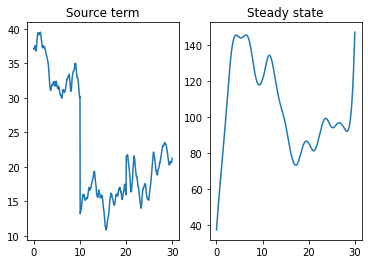

In [17]:
plt.subplot(1,2,1)
plot(source_f,title='Source term')
plt.subplot(1,2,2)
plot(w,title='Steady state')
plt.show()

In [18]:
# Get observations
num_samp = 20
sigma2_eps = 10   
pt_inds = list(map(int,np.linspace(0,num_pt,num_samp)))
x = np.linspace(xL,xR,num_pt+1)
pts = x[pt_inds]
data = random.normal(scale=np.sqrt(sigma2_eps),size=num_samp) + [w(pt) for pt in pts]
O = make_obs_mat_pts([[pt] for pt in pts],fem,mesh,V,threshold=1e-10)
# this is what it used to be but 
# then it seems like we aren't observing beta?
O = sparse.bmat([[O],[np.zeros((len(beta),num_samp))]]) 
# this is what it seems like it ought to be, but doesn't work?
# O = sparse.bmat([[O],[X.transpose()@O]]) # SEE writeup the original is indeed correct

In [19]:
Q_beta = sparse.diags(np.array([1/sigma_beta for i in range(3)]))
Q_prior = sparse.bmat([[K.transpose() @ invL @ Q_source @ invL @ K,-K.transpose() @ invL @ Q_source @ X],[-X.transpose() @ Q_source @ invL @ K,Q_beta + X.transpose() @ Q_source @ X]])
Q_post  = Q_prior + O @ O.transpose()/sigma2_eps

In [20]:
mean_soln = (splinalg.spsolve(Q_post,O @ data)/sigma2_eps)[0:(num_pt+1)]
mean_source = invL @ K @ mean_soln
soln_est = vec_to_func(mean_soln,V)
source_est = vec_to_func(mean_source,V)

In [21]:
cov_post = splinalg.inv(Q_post)
cov_post_u = cov_post[0:(num_pt+1),0:(num_pt+1)]
std_post_simul = simultaneous_confint(cov_post_u.todense(),1000) 
std_post = np.sqrt(cov_post_u.diagonal())
std_soln_f = vec_to_func(std_post,V)
std_soln_f_simul = vec_to_func(std_post_simul,V)

cov_post_source = invL @ K @ cov_post_u @ K.transpose() @ invL
std_post_source_simul = simultaneous_confint(cov_post_source.todense(),1000) 
std_post_source = np.sqrt(cov_post_source.diagonal()) 
std_source_f = vec_to_func(std_post_source,V)
std_source_f_simul = vec_to_func(std_post_source_simul,V)

/Users/cokasaki/opt/anaconda3/envs/spde/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/Users/cokasaki/opt/anaconda3/envs/spde/lib/python3.9/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/Users/cokasaki/ownCloud/Work/Research/spat_stat/final_writeup/publication_github/general/util.py:28: RuntimeWarning: covariance is not positive-semidefinite.
  sim = random.multivariate_normal(np.zeros(dim),cov,size=num_sim)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


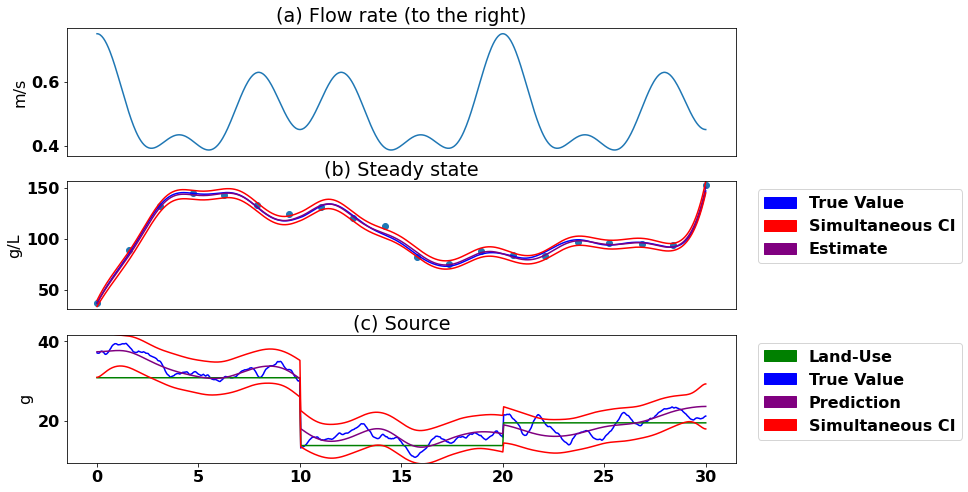

In [35]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

plt.figure(figsize=(12,8))
plt.subplot(3,1,1)
plt.plot(x,[adv(xi) for xi in x])
plt.ylabel("m/s")
plt.title('(a) Flow rate (to the right)')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
plt.subplot(3,1,2)
plot(w,color='b',title='(b) Steady state')
plt.ylabel("g/L")
plot(soln_est,color='purple')
plot(soln_est + 1.96*std_soln_f,color='r')
plot(soln_est - 1.96*std_soln_f,color='r')
plt.scatter(pts,data)
plt.ylim(np.min(mean_soln)-2*np.max(std_post),np.max(mean_soln)+2*np.max(std_post))
b = mpatches.Patch(color='b', label='True Value')
r = mpatches.Patch(color='r', label='Simultaneous CI')
p = mpatches.Patch(color='purple', label='Estimate')
plt.legend(handles=[b,r,p],bbox_to_anchor=(1.02,1),loc="upper left")
frame2 = plt.gca()
frame2.axes.get_xaxis().set_ticks([])
plt.subplot(3,1,3)
plot(source_f,color='b',title='(c) Source')
plt.ylabel("g")
plot(x_f,color='g')
plot(source_est,color='purple')
#plot(source_est + std_source_f,color='r')
#plot(source_est - std_source_f,color='r')
plot(source_est + 1.96*std_source_f,color='r')
plot(source_est - 1.96*std_source_f,color='r')
plt.ylim(np.min(mean_source)-1.2*np.max(std_post_source),np.max(mean_source)+1.2*np.max(std_post_source))
handles = [mpatches.Patch(color='g', label='Land-Use'),
           mpatches.Patch(color='b', label='True Value'),
           mpatches.Patch(color='purple', label='Prediction'),
           mpatches.Patch(color='r', label='Simultaneous CI')]
plt.legend(handles=handles,bbox_to_anchor=(1.02,1),loc="upper left")
frame3 = plt.gca()
plt.savefig("../figs/adv_diff_1d.png")

Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


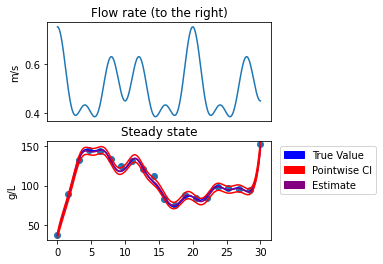

In [23]:
plt.figure(figsize=(4,4))
plt.subplot(2,1,1)
plt.plot(x,[adv(xi) for xi in x])
plt.ylabel("m/s")
plt.title('Flow rate (to the right)')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
plt.subplot(2,1,2)
plot(w,color='b',title='Steady state')
plt.ylabel("g/L")
plot(soln_est,color='purple')
#plot(soln_est + std_f,color='r')
#plot(soln_est - std_f,color='r')
plot(soln_est + 1.96*std_soln_f,color='r')
plot(soln_est - 1.96*std_soln_f,color='r')
plt.scatter(pts,data)
plt.ylim(np.min(mean_soln)-2*np.max(std_post),np.max(mean_soln)+2*np.max(std_post))
b = mpatches.Patch(color='b', label='True Value')
r = mpatches.Patch(color='r', label='Pointwise CI')
p = mpatches.Patch(color='purple', label='Estimate')
plt.legend(handles=[b,r,p],bbox_to_anchor=(1.02,1),loc="upper left")
frame2 = plt.gca()
plt.show()

Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


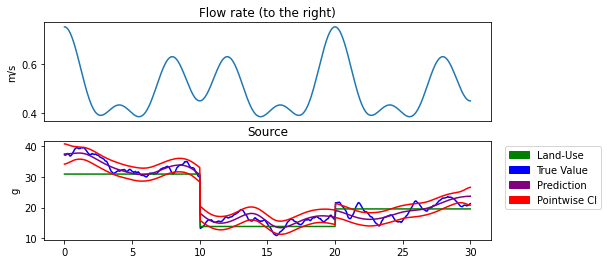

In [24]:
plt.figure(figsize=(8,4))
plt.subplot(2,1,1)
plt.plot(x,[adv(xi) for xi in x])
plt.ylabel("m/s")
plt.title('Flow rate (to the right)')
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
plt.subplot(2,1,2)
plot(source_f,color='b',title='Source')
plt.ylabel("g")
plot(x_f,color='g')
plot(source_est,color='purple')
plot(source_est + std_source_f,color='r')
plot(source_est - std_source_f,color='r')
# plot(source_est + 1.96*std_source_f_2,color='g')
# plot(source_est - 1.96*std_source_f_2,color='g')
plt.ylim(np.min(mean_source)-1.2*np.max(std_post_source),np.max(mean_source)+1.2*np.max(std_post_source))
handles = [mpatches.Patch(color='g', label='Land-Use'),
           mpatches.Patch(color='b', label='True Value'),
           mpatches.Patch(color='purple', label='Prediction'),
           mpatches.Patch(color='r', label='Pointwise CI')]
plt.legend(handles=handles,bbox_to_anchor=(1.02,1),loc="upper left")
frame3 = plt.gca()
plt.show()

Now let's take a look at the L2 norm to quantify overall accuracy on the source and solution

In [25]:
# L2-norm distances between true and estimate
print(sqrt(assemble((source_f-source_est)**2*dx)))
print(sqrt(assemble((w-soln_est)**2*dx)))
print("~")
# L2-norm distances between true and estimate, scaled by L2-norm of true
print(sqrt(assemble((source_f-source_est)**2*dx)/assemble(source_f**2*dx)))
print(sqrt(assemble((w-soln_est)**2*dx)/assemble(soln_est**2*dx)))

8.344060764903038
7.604465488458678
~
0.06256412045959174
0.012862736528150774


In [26]:
const1 = Expression("1",degree=1)
const1_f = Function(V)
const1_f.interpolate(const1)
shifted_source = source_f - assemble(source_f*dx)/assemble(const1_f*dx)
shifted_soln = w - assemble(w*dx)/assemble(const1_f*dx)

In [27]:
# L2-norm distances between true and estimate, scaled by L2-norm of true after removing mean
print(sqrt(assemble((source_f-source_est)**2*dx)/assemble(shifted_source**2*dx)))
print(sqrt(assemble((w-soln_est)**2*dx)/assemble(shifted_soln**2*dx)))

0.18539236323362704
0.057275783821296555


Now that we can calculate what effective fraction of the L2 variation from the mean is explained by our model, let's plot this as a function of # of equally spaced data points

In [28]:
def soln_and_source_error(num_samp,source=source_f,soln=w):
    pt_inds = list(map(int,np.linspace(0,num_pt,num_samp)))
    x = np.linspace(xL,xR,num_pt+1)
    pts = x[pt_inds]
    data = random.normal(scale=np.sqrt(sigma2_eps),size=num_samp) + [soln(pt) for pt in pts]
    O = make_obs_mat_pts([[pt] for pt in pts],fem,mesh,V,threshold=1e-10)
    O = sparse.bmat([[O],[np.zeros((len(beta),num_samp))]])
    
    Q_beta = sparse.diags(np.array([1/sigma_beta for i in range(3)]))
    Q_prior = sparse.bmat([[K.transpose() @ invL @ Q_source @ invL @ K,-K.transpose() @ invL @ Q_source @ X],[-X.transpose() @ Q_source @ invL @ K,Q_beta + X.transpose() @ Q_source @ X]])
    Q_post  = Q_prior + O @ O.transpose()/sigma2_eps
    
    mean_soln = (splinalg.spsolve(Q_post,O @ data)/sigma2_eps)[0:(num_pt+1)]
    mean_source = invL @ K @ mean_soln
    soln_est = vec_to_func(mean_soln,V)
    source_est = vec_to_func(mean_source,V)
    
    shifted_source = source - assemble(source*dx)/assemble(const1_f*dx)
    shifted_soln = soln - assemble(soln*dx)/assemble(const1_f*dx)
    
    source_error = sqrt(assemble((source-source_est)**2*dx)/assemble(shifted_source**2*dx))
    soln_error = sqrt(assemble((soln-soln_est)**2*dx)/assemble(shifted_soln**2*dx))
    return source_error,soln_error

def sim_soln_and_source_error(numsamps,num_sim=1):
    
    if num_sim==1:
        mu_beta = 20
        sigma_beta = 5
        X = np.array([farm_vec,ind_vec,res_vec]).transpose()
        beta = random.normal(loc=mu_beta,scale=sigma_beta,size=3)
        source_vec = np.squeeze(mvn_invchol(Q_factors,num_pt+1)) + beta[0]*farm_vec + beta[1]*ind_vec + beta[2]*res_vec
        source = vec_to_func(source_vec,V)
        x_f = vec_to_func(beta[0]*farm_vec + beta[1]*ind_vec + beta[2]*res_vec,V)
        soln = Function(V)
        solve(equation==source*v*dx,soln)
        return np.array([soln_and_source_error(x,source,soln) for x in numsamps])
    else:
        return [sim_soln_and_source_error(numsamps) for i in range(num_sim)]
    

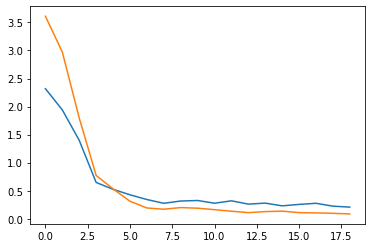

In [29]:
errors = [soln_and_source_error(x) for x in range(1,20)]
plt.plot(errors)
plt.show()

In [30]:
nsim = 30
numsamps = [x**2 for x in range(2,15)]
sim_errors = sim_soln_and_source_error(numsamps,nsim)
error_sums = 0
for i in range(nsim):
    error_sums += sim_errors[1]
error_means = error_sums / nsim

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

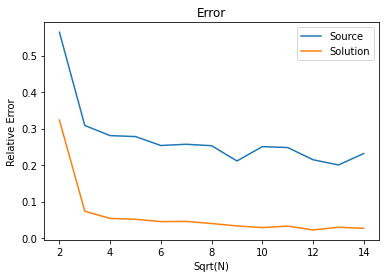

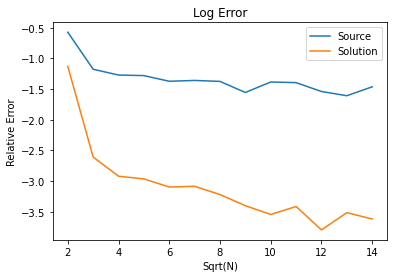

In [31]:
ax = plt.gca()
ax.plot(np.sqrt(numsamps),[m[0] for m in error_means],label="Source")
ax.plot(np.sqrt(numsamps),[m[1] for m in error_means],label="Solution")
ax.legend()
ax.set_title("Error")
ax.set_ylabel("Relative Error")
ax.set_xlabel("Sqrt(N)")
plt.show()


ax = plt.gca()
ax.plot(np.sqrt(numsamps),[np.log(m[0]) for m in error_means],label="Source")
ax.plot(np.sqrt(numsamps),[np.log(m[1]) for m in error_means],label="Solution")
ax.legend()
ax.set_title("Log Error")
ax.set_ylabel("Relative Error")
ax.set_xlabel("Sqrt(N)")
plt.show()